# Having fun with the ROSCO toolbox 
#### By: Nikhar J. Abbas, December 12, 2019
Here is a little jupyter notebook describing some of the functionalities of the ROSCO toolbox. The goal here is to walk through the process of writing a turbine controller for a new wind turbine model. 

If you somehow managed to get your hands on this notebook without knowing of it's git repository of origin, here is a link: 

<center> <a>https://github.com/NREL/ROSCO_toolbox</a> </center>


Hopefully you'll learn some hot tips along the way...


In [1]:
# Load necessary modules
# Python Modules
import os, platform
import matplotlib.pyplot as plt 
import pprint
import numpy as np

# ROSCO Modules
from ROSCO_toolbox import turbine as ROSCO_turbine
from ROSCO_toolbox import utilities as ROSCO_utilities
from ROSCO_toolbox import sim as ROSCO_sim
from ROSCO_toolbox import utilities as ROSCO_utilities
from ROSCO_toolbox import controller as ROSCO_controller
from ROSCO_toolbox import control_interface as ROSCO_ci
from ROSCO_toolbox.ofTools.fast_io.output_processing import output_processing

from ROSCO_toolbox.inputs.validation import load_rosco_yaml



Using ofTools in ROSCO_toolbox...


/Users/dzalkind/opt/anaconda3/envs/rosco-env/lib/python3.8/site-packages/openmdao/utils/general_utils.py:130: OMDeprecationWarning:simple_warning is deprecated. Use openmdao.utils.om_warnings.issue_warning instead.
/Users/dzalkind/opt/anaconda3/envs/rosco-env/lib/python3.8/site-packages/openmdao/utils/notebook_utils.py:171: UserWarning:Tabulate is not installed. Run `pip install openmdao[notebooks]` to install required dependencies. Using ASCII for outputs.


## .yaml files 
We use yaml files as the top level input file to the ROSCO generic tuning process.

### Three main parts:
* Path Parameters
    - Contains the path details of the OpenFAST input fails
* Turbine Parameters
    - Contains some high level turbine parameters. Rated power, important wind speeds, etc...
* Controller Parameters
    - Contains the controller parameters. Some are necessary, the rest are optional
    
#### Lets load and look at our controller paremeters...

In [2]:
# Load yaml file 
parameter_filename = '../Tune_Cases/NREL5MW.yaml'
inps = load_rosco_yaml(parameter_filename)
path_params         = inps['path_params']
turbine_params      = inps['turbine_params']
controller_params   = inps['controller_params']

In [3]:
pprint.pprint(turbine_params)

{'TSR_operational': 0,
 'bld_edgewise_freq': 6.2831853,
 'bld_flapwise_freq': 0.0,
 'max_pitch_rate': 0.1745,
 'max_torque_rate': 1500000.0,
 'rated_power': 5000000.0,
 'rated_rotor_speed': 1.26711,
 'rotor_inertia': 38677040.613,
 'v_max': 25.0,
 'v_min': 3.0,
 'v_rated': 11.4}


### So, what do we care about here?
Note that items with a star need at least a 0 or a 1. They're fairly standard, though...
1. Filter types
    * A few are available. Generally, first and second order low pass filters, high pass, and notch. They are used for a few different purposes
2. Control Modes
    * Which control modes you would like. There are a few different options, example .yaml files are provided in the toolbox.
3. omega_* and zeta_*
    * These are the __four__ controller tuning parameters that you need to define. Again, some example files for different turbines are provided to help build some intuition on these.
4. The rest..
    * The rest of these are optional. If you would like to define these, go for it. Otherwise you don't need to

## Loading a Turbine model
We will load a turbine model and look at it a bit. Note that `path_params['rotor_performance_filename']` is defined, so we will not run CC-blade in this tutorial. You could though, if you have a couple minutes!

In [4]:
# Load turbine data from openfast model
turbine = ROSCO_turbine.Turbine(turbine_params)
turbine.load_from_fast(path_params['FAST_InputFile'],path_params['FAST_directory'],dev_branch=True,rot_source='txt',txt_filename=path_params['rotor_performance_filename'])


-----------------------------------------------------------------------------
Loading wind turbine data for NREL's ROSCO tuning and simulation processeses
-----------------------------------------------------------------------------
Loading FAST model: NREL-5MW.fst 
Loading rotor performace data from text file: /Users/dzalkind/Tools/ROSCO/Test_Cases/NREL-5MW/Cp_Ct_Cq.NREL5MW.txt
Loading rotor performace data from text file: Cp_Ct_Cq.NREL5MW.txt


### Look at some basic turbine information and plot a Cp-surface

-------------- Turbine Info --------------
Turbine Name: NREL-5MW
Rated Power: 5000000.0 [W]
Total Inertia: 43702538.1 [kg m^2]
Rotor Radius: 63.0 [m]
Rated Rotor Speed: 1.3 [rad/s]
Max Cp: 0.47
------------------------------------------
 


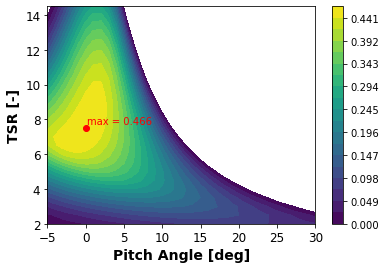

In [5]:
print(turbine)
# Plot rotor performance information
turbine.Cp.plot_performance()
plt.show()

## Tune a controller
We now have loaded our wind turbine model. Lets tune the controller 

In [6]:
# Tune controller 
controller      = ROSCO_controller.Controller(controller_params)
controller.tune_controller(turbine)

-----------------------------------------------------------------------------
   Tuning a reference wind turbine controller using NREL's ROSCO toolbox    
-----------------------------------------------------------------------------


**WOW! That was easy...**

Lets plot our PI gains and write the ROSCO input file

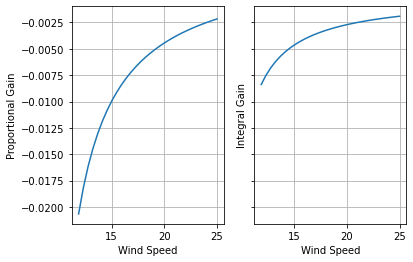

In [7]:
# Plot gain schedule
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].plot(controller.v[len(controller.v_below_rated)+1:], controller.pc_gain_schedule.Kp)
axs[0].set_xlabel('Wind Speed')
axs[0].set_ylabel('Proportional Gain')
axs[0].grid('True')


axs[1].plot(controller.v[len(controller.v_below_rated)+1:], controller.pc_gain_schedule.Ki)
axs[1].set_xlabel('Wind Speed')
axs[1].set_ylabel('Integral Gain')
axs[1].grid('True')


In [8]:
# Write parameter input file
param_file = 'DISCON.IN'   # This must be named DISCON.IN to be seen by the compiled controller binary. 
ROSCO_utilities.write_DISCON(turbine,controller,param_file=param_file, txt_filename=path_params['rotor_performance_filename'])

Writing new controller parameter file parameter file: DISCON.IN.


### What else can the controller do and see?
Lets look at our minimum pitch schedule. We will need to:
1. Change `PS_Mode = 1` for peak chaving
2. Retune the controller. Let's call it `controller_ps`
3. Plot the results

-----------------------------------------------------------------------------
   Tuning a reference wind turbine controller using NREL's ROSCO toolbox    
-----------------------------------------------------------------------------


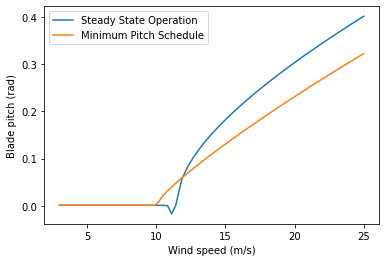

In [9]:
# Change pitch saturation parameter to peak shave
controller_params['PS_Mode'] = 1

# Retune the controller
controller2 = ROSCO_controller.Controller(controller_params)
controller2.tune_controller(turbine)

# Plot minimum pitch schedule
plt.plot(controller2.v, controller2.pitch_op,label='Steady State Operation')
plt.plot(controller2.v, controller2.ps_min_bld_pitch, label='Minimum Pitch Schedule')
plt.legend()
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Blade pitch (rad)')
plt.show()

### Quick Simulate..
We can also run a small one degree of freedom simulation to see if our tuning makes sense

                                                                               
------------------------------------------------------------------------------
Running ROSCO-v2.5.0
A wind turbine controller framework for public use in the scientific field    
Developed in collaboration: National Renewable Energy Laboratory              
                            Delft University of Technology, The Netherlands   
------------------------------------------------------------------------------
Generator speed:    9.5 RPM, Pitch angle:   0.0 deg, Power:     0.0 kW, Est. wind Speed:  10.0 m/s
Generator speed:  673.4 RPM, Pitch angle:   0.1 deg, Power:   340.7 kW, Est. wind Speed:   4.6 m/s
Generator speed:  751.3 RPM, Pitch angle:   0.1 deg, Power:   853.4 kW, Est. wind Speed:   7.1 m/s
Generator speed:  800.7 RPM, Pitch angle:   0.1 deg, Power:  1072.2 kW, Est. wind Speed:   6.8 m/s
Generator speed:  781.4 RPM, Pitch angle:   0.1 deg, Power:  1190.5 kW, Est. wind Speed:   6.8 m/s
Generator

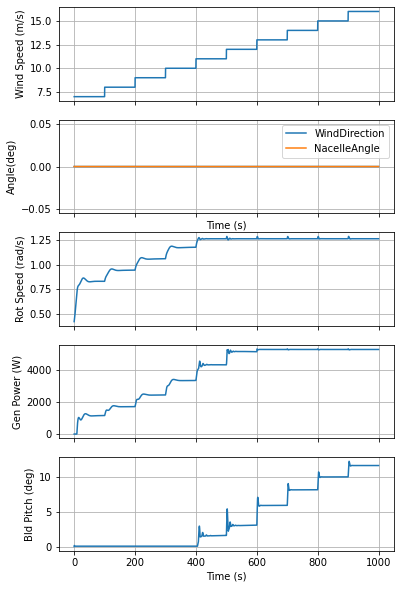

In [10]:
# Specify controller dynamic library path and name

if platform.system() == 'Windows':
    ext = 'dll'
elif platform.system() == 'Darwin':
    ext = 'dylib'
else:
    ext = 'so'
                
lib_name = (f'../ROSCO/build/libdiscon.{ext}')

# Load the simulator and controller interface
controller_int = ROSCO_ci.ControllerInterface(lib_name)
sim = ROSCO_sim.Sim(turbine,controller_int)

# Define a wind speed history
dt = 0.1
tlen = 1000      # length of time to simulate (s)
ws0 = 7         # initial wind speed (m/s)
t= np.arange(0,tlen,dt) 
ws = np.ones_like(t) * ws0
# add steps at every 100s
for i in range(len(t)):
    ws[i] = ws[i] + t[i]//100

# Run simulator and plot results
sim.sim_ws_series(t,ws,rotor_rpm_init=4)
plt.show()

Note that his doesn't look _exactly_ how we would like our final controller to behave. This tool (currently) is to help build some intuition on if the controller is working reasonably. It does not have any significant dynamics, though.

## OpenFAST Runs
We could run an OpenFAST simulation, but that will take some time. You will have to trust me that it works. See example 6 if you don't. We look at some post-processing stuff though...

### Post processing OpenFAST
Currently, we have some basic plotting functionalities available. This is nice, as it gives us the chance to quickly and alogithmically look at some relevant control signals. 

#### Step wind case

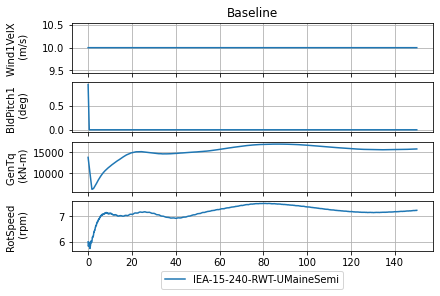

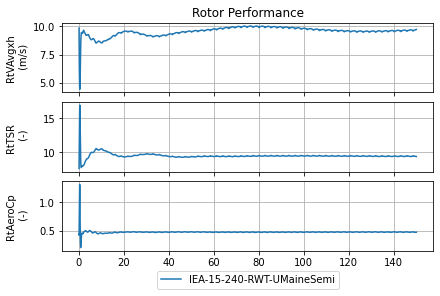

([<Figure size 432x288 with 4 Axes>, <Figure size 432x288 with 3 Axes>],
 [array([<AxesSubplot:title={'center':'Baseline'}, ylabel='Wind1VelX \n (m/s)'>,
         <AxesSubplot:ylabel='BldPitch1 \n (deg)'>,
         <AxesSubplot:ylabel='GenTq \n (kN-m)'>,
         <AxesSubplot:ylabel='RotSpeed \n (rpm)'>], dtype=object),
  array([<AxesSubplot:title={'center':'Rotor Performance'}, ylabel='RtVAvgxh \n (m/s)'>,
         <AxesSubplot:ylabel='RtTSR \n (-)'>,
         <AxesSubplot:ylabel='RtAeroCp \n (-)'>], dtype=object)])

In [11]:
op = output_processing()

# Define openfast output filenames, please fill in your own .outb
# filenames = ["../Test_Cases/5MW_Step/5MW_Step.outb"]
filenames = ['../Test_Cases/IEA-15-240-RWT-UMaineSemi/IEA-15-240-RWT-UMaineSemi.outb']
# Load output info and data
fast_out = op.load_fast_out(filenames)

#  Define Plot cases 
cases = {}
cases['Baseline'] = ['Wind1VelX', 'BldPitch1', 'GenTq', 'RotSpeed']
cases['Rotor Performance'] = ['RtVAvgxh', 'RtTSR', 'RtAeroCp']

# Plot, woohoo!
op.plot_fast_out(fast_out, cases)

#### Turbulent wind case
Lets look at the near turbulent cases with and without peak shaving (80%)

In [12]:
# # Define openfast output filenames
# filenames = ["../Test_Cases/5MW_Turb_NR/5MW_Turb_NR.out", # Note that we can load txt or binary outputs
#              "../Test_Cases/5MW_Turb_NR_ps/5MW_Turb_NR_ps.outb"]

# # Load output info and data
# fast_out = op.load_fast_out(filenames)

# #  Define Plot cases 
# cases = {}
# cases['Baseline'] = ['Wind1VelX', 'BldPitch1', 'GenTq', 'RotSpeed']
# cases['Peak Shaving'] = ['Wind1VelX', 'BldPitch1', 'TwrBsMyt']

# # Plot, woohoo!
# op.plot_fast_out(fast_out, cases)

## In conclusion
Hopefully this jupyter notebook showed some good working examples of what the overall functions of the ROSCO toolbox and associated ROSCO controller have to offer. Of course, I encourage you all to dig into the code a bit more. There are a number of examples offered in Examples folder (shockingly). These go over a number of the same functionalities that this notebook did, but in a little bit more detail and perhaps a more functional way. 

Of course, please offer your feedback on where you can see advancements in any of this work. You can reach me personally at nikhar.abbas@nrel.gov, or submit any issue/pull requests to the associated git repository itself. This project is meant to be ongoing and continue to evolve - and I would REALLY love the help in doing so!

I would finally like to note that there has been a lot of work from a lot of very smart (and really great) people that has gone into all of this, some of which are acknowledged on the [ROSCO toolbox](www.github.com/nrel/ROSCO_toolbox) and [ROSCO](www.github.com/nrel/ROSCO_toolbox) github pages. 